Outlier Detection
=====

### Reference  
### https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate
### https://ko.logpresso.com/documents/anomaly-detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

## 1. Parametric methods : Univariate

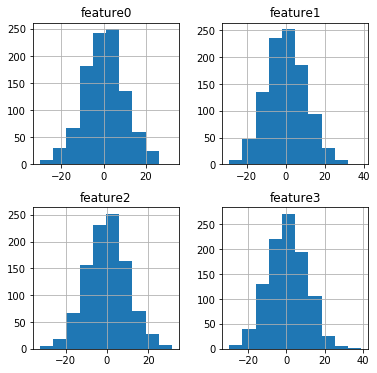

In [2]:
# seed for reproducibility
np.random.seed(42)
n_feats = 4
dummydf = pd.DataFrame(np.random.normal(scale=10.0, size=(1000, n_feats)),
                      columns = ['feature{}'.format(i) for i in range(n_feats)])

# all eaually distributed
dummydf.hist(figsize=(6,6))
plt.show()

In [3]:
# see if enough variation between features to show outliers
# min에서 이상치를 찾을 수 있음
dummydf.describe()

,feature0,feature1,feature2,feature3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.306239,0.248285,-0.082552,0.300861
std,9.639191,10.118843,10.060754,10.069640
min,-30.195122,-28.962554,-32.412673,-29.911360
25%,-6.129422,-6.770368,-6.752986,-6.708710
50%,0.561874,0.202097,-0.075088,0.211577
75%,6.648813,6.938808,6.422820,6.958780
max,32.430930,38.527315,31.520567,39.262377


### 1) standard deviation method

In [4]:
# 지정한 std 범주 바깥에 속하는 값을 outlier로 지정함
def out_std(s, nstd=3.0, return_thresholds=False):
    
    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]
    
outlier_mask = out_std(dummydf['feature0'], nstd=3.0)
outlier_mask[:10]  # print first 10 elements

[False, False, False, False, False, False, False, False, False, False]

In [5]:
# identify the outliers
dummydf['feature0'][outlier_mask]

506   -30.195122
788   -29.069882
929    32.430930
Name: feature0, dtype: float64

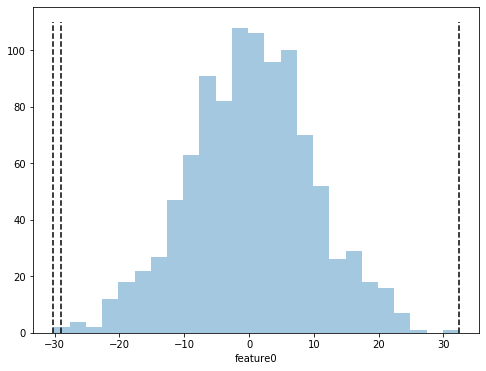

In [6]:
# visualize the results
# outlier가 있는 부분을 시각화함
plt.figure(figsize=(8, 6))
sns.distplot(dummydf['feature0'], kde=False)
plt.vlines(dummydf['feature0'][outlier_mask], ymin=0, ymax=110,
           linestyles='dashed')
plt.show()

### 2) percentile method

In [9]:
# 25%, 75% 에 약간의 값을 더한 값보다 더 큰 경우 outlier로 지정함
def out_iqr(s, k=1.5, return_thresholds=False):
    
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]
    
outlier_mask_iqr = out_iqr(dummydf['feature0'], k=1.5)
outlier_mask_iqr[:10]  # print first 10 elements
dummydf['feature0'][outlier_mask_iqr]

167   -26.509698
506   -30.195122
639   -26.357477
721   -27.475048
788   -29.069882
929    32.430930
Name: feature0, dtype: float64

### 3) Compare Standard Deviation and IQR

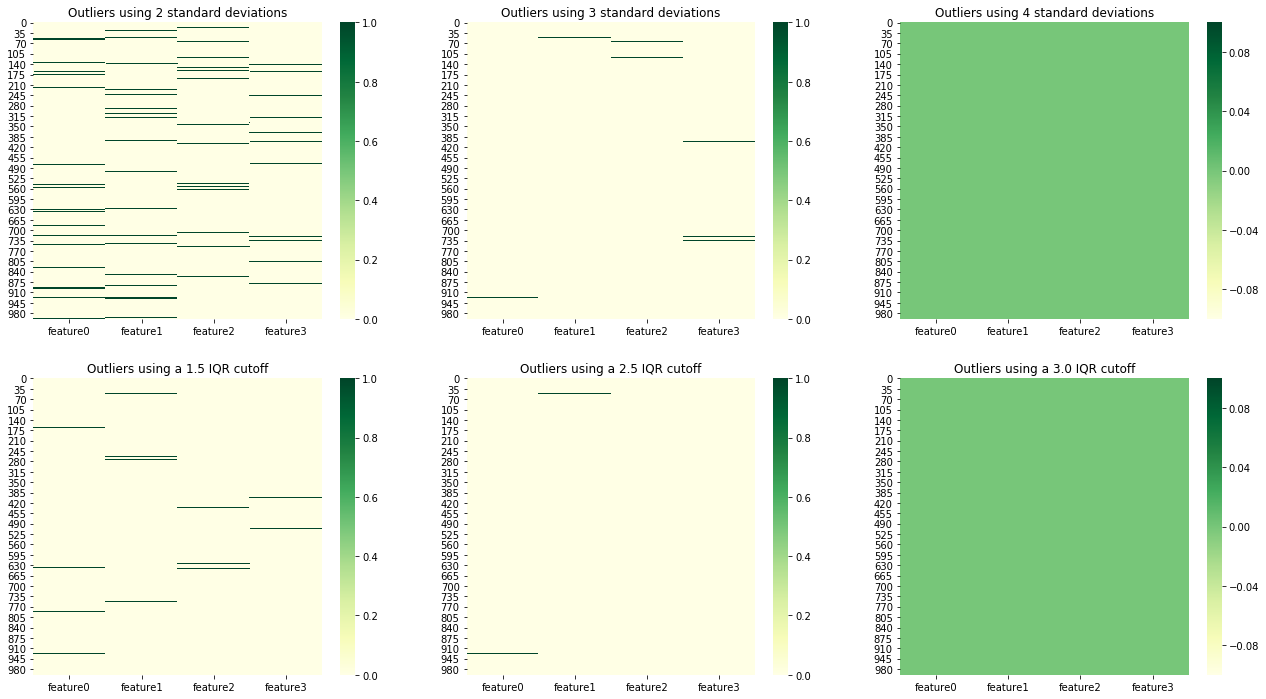

In [13]:
# 3 std는 99.97%의 데이터를 포함하기에 대부분 다 정상값으로 감지함
std2 = dummydf.apply(out_std, nstd=2.0)
std3 = dummydf.apply(out_std, nstd=3.0)
std4 = dummydf.apply(out_std, nstd=4.0)

iqr1 = dummydf.apply(out_iqr, k=1.5)
iqr2 = dummydf.apply(out_iqr, k=2.0)
iqr3 = dummydf.apply(out_iqr, k=3.0)

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows=2, figsize=(22, 12));
ax1.set_title('Outliers using 2 standard deviations')
ax2.set_title('Outliers using 3 standard deviations')
ax3.set_title('Outliers using 4 standard deviations')
ax4.set_title('Outliers using a 1.5 IQR cutoff')
ax5.set_title('Outliers using a 2.5 IQR cutoff')
ax6.set_title('Outliers using a 3.0 IQR cutoff')

sns.heatmap(std2, cmap='YlGn', ax=ax1)
sns.heatmap(std3, cmap='YlGn', ax=ax2)
sns.heatmap(std4, cmap='YlGn', ax=ax3)
sns.heatmap(iqr1, cmap='YlGn', ax=ax4)
sns.heatmap(iqr2, cmap='YlGn', ax=ax5)
sns.heatmap(iqr3, cmap='YlGn', ax=ax6)

plt.show()

In [14]:
# outlier 부분을 axvspan을 통해 강조하는 함수
def plot_cutoff(dataframe, col, nstd=2.0, color='red'):
    
    lower, upper = out_std(dataframe[col], nstd=nstd, return_thresholds=True)
    # outlier 부분을 강조하는 plot
    plt.axvspan(min(dataframe[col][dataframe[col] < lower], default=dataframe[col].min()), lower, alpha=0.2, color=color)
    plt.axvspan(upper, max(dataframe[col][dataframe[col] > upper], default=dataframe[col].max()), alpha=0.2, color=color)

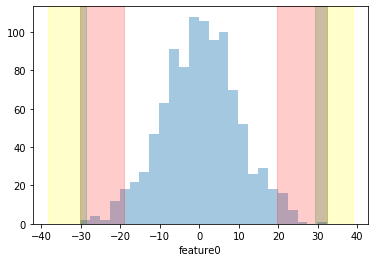

In [15]:
column = 'feature0'
sns.distplot(dummydf[column], kde=False)
plot_cutoff(dummydf, column, nstd=2.0, color='red')
plot_cutoff(dummydf, column, nstd=3.0, color='green')
plot_cutoff(dummydf, column, nstd=4.0, color='yellow')

## 2. Nonparametric methods(Univariate) : Isolation Forest

In [16]:
df = pd.read_csv('data/Melbourne_housing_FULL.csv')

df.fillna(df.median(), inplace = True)

df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,870000.0,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,136.0,1970.0,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,136.0,1970.0,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,870000.0,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,136.0,1970.0,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [17]:
# limit the columns -> numeric features
cols = cols = ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'Propertycount']

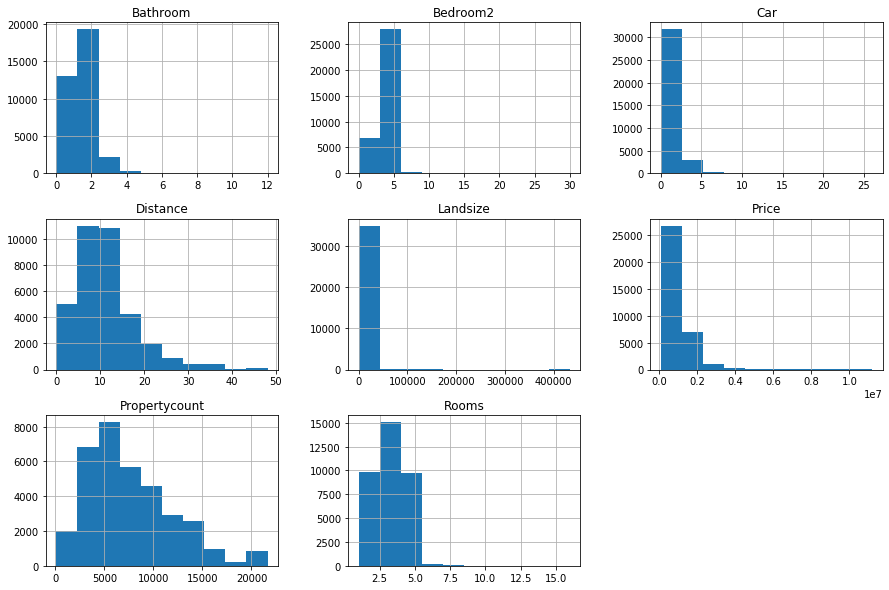

In [19]:
# visualizethe distribution
df[cols].hist(figsize=(15,10))
plt.show()

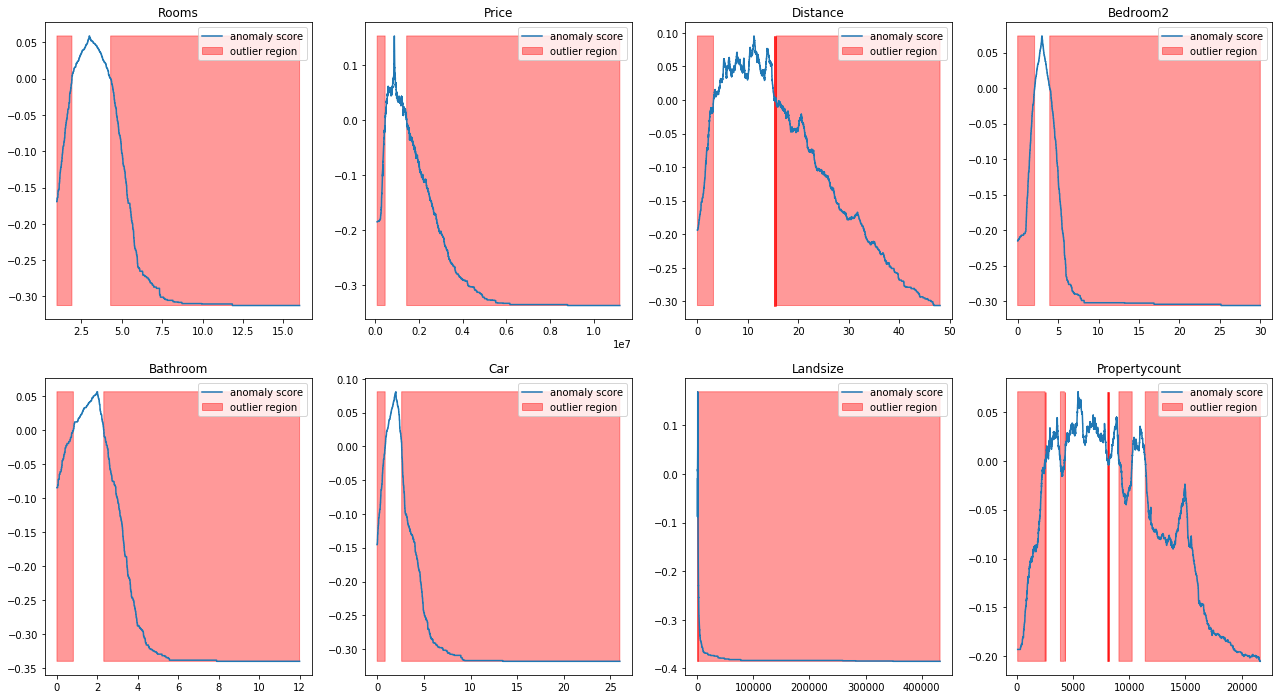

In [23]:
# Isolation Forest

fig, axs = plt.subplots(2, 4, figsize=(22, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto', behaviour='new')
    isolation_forest.fit(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

## 3. Parametric methods(Multivariate) : EllipticEnvelop

Text(0.5, 0, 'feature0')

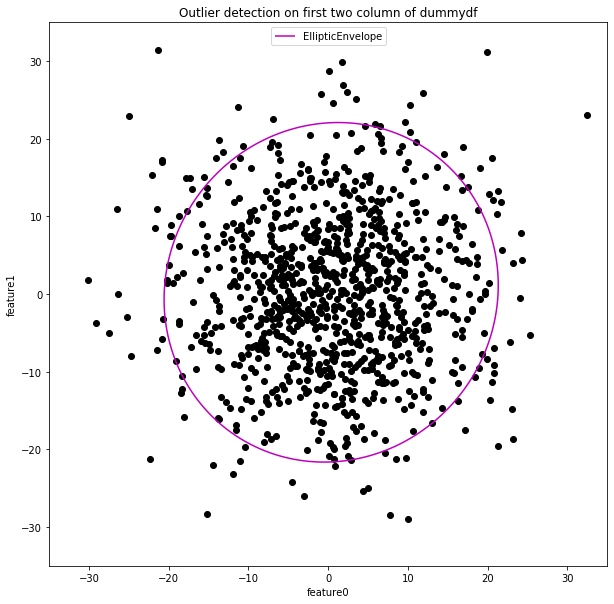

In [27]:
# EllipticEnvelop
import warnings

warnings.filterwarnings('ignore')

clf = EllipticEnvelope()

legend = {}
xx, yy = np.meshgrid(np.linspace(-35, 35, 500), np.linspace(-35,35,500))

plt.figure(1, figsize=(10,10))
clf.fit(dummydf.values[:, :2])
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
legend['EllipticEnvelope'] = plt.contour(
    xx, yy, Z, levels=[0], linewidth=2, colors=['m'])

legend_values_list = list(legend.values())
legend_keys_list = list(legend.keys())

plt.figure(1, figsize=(10,10))
plt.title('Outlier detection on first two column of dummydf')
plt.scatter(dummydf.values[:, 0], dummydf.values[:, 1], color='black')
bbox_args = dict(boxstyle='round', fc='0.8')
arrow_args = dict(arrowstyle='->')

plt.xlim((xx.min(), xx.max()))
plt.ylim((yy.min(), yy.max()))
plt.legend(legend_values_list[0].collections, legend_keys_list, 
          loc='upper center')
plt.ylabel('feature1')
plt.xlabel('feature0')

## 4. Nonparametric methods(Multivariate)

### 1) DBSCAN

In [31]:
# scale the data
X = StandardScaler().fit_transform(df[cols].values)

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = db.labels_

In [32]:
pd.Series(labels).value_counts()

-1      11495
 3       4673
 0       2261
 4       1900
 18      1763
        ...  
 67         9
 157        9
 168        8
 59         7
 68         6
Length: 201, dtype: int64

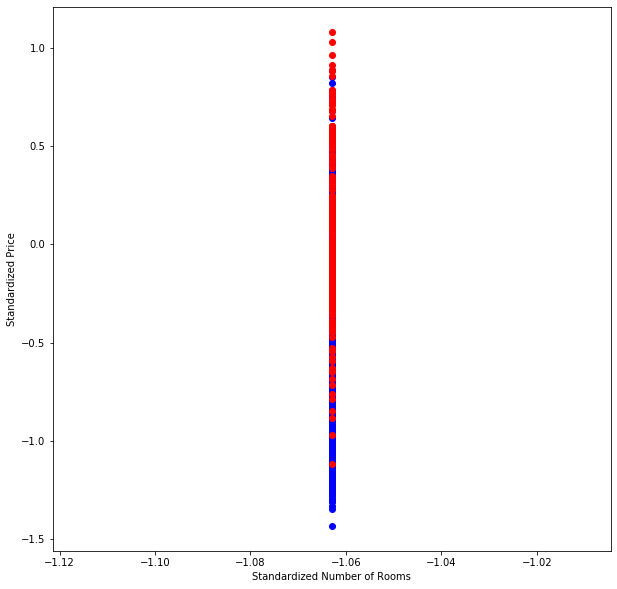

In [30]:
plt.figure(figsize=(10,10))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask], X[:, 1][sample_mask], 'o', color=color);
plt.xlabel('Standardized Number of Rooms');
plt.ylabel('Standardized Price');

### 2) LocalOutlierFactor

In [33]:
clf = LocalOutlierFactor(n_neighbors=50, contamination='auto')
y_pred = clf.fit_predict(X[:,:2])

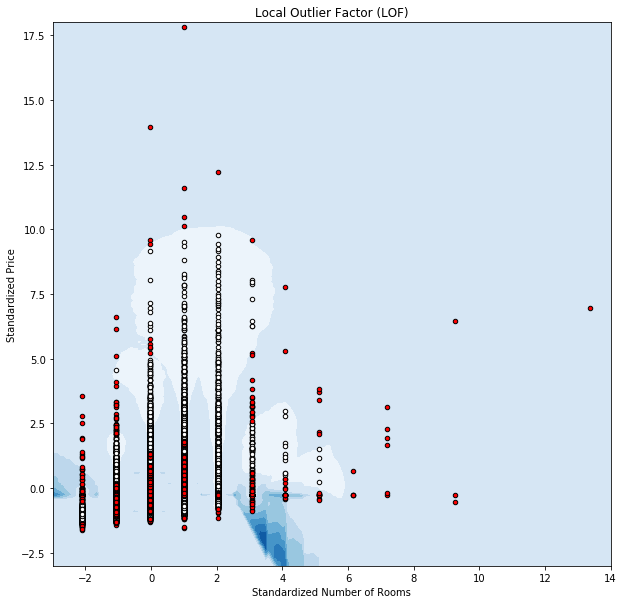

In [34]:
plt.figure(figsize=(10,10))
# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-3, 14, num=200), np.linspace(-3, 18, num=200))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c='white',
                edgecolor='k', s=20)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c='red',
                edgecolor='k', s=20)
plt.axis('tight')
plt.xlabel('Standardized Number of Rooms');
plt.ylabel('Standardized Price');
plt.show()